# Fantasy football wide-receivers points prediction model using neural network

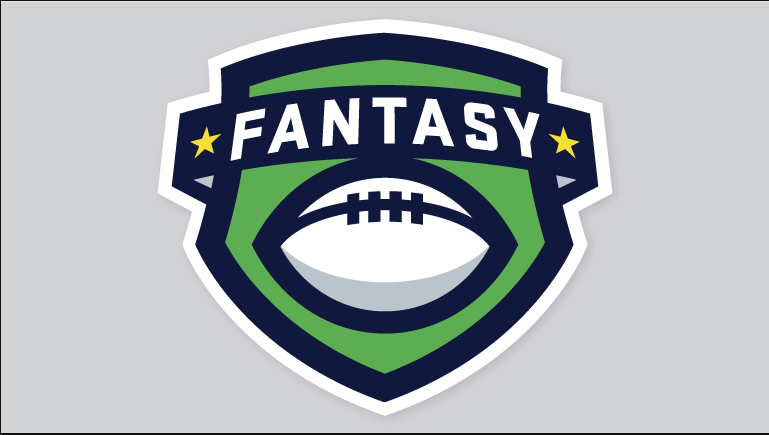


#### Goal of the project : Create a model that will predict the number of points NFL wide receiver should score in the upcoming 2022-2023 season.

#### How : Make use of the massive amount of readily available data on players/fantasy scoring within a neural network.

#### Framework :
    - Standard fantasy football points scoring system
    - Isolate wide-receiver scoring, but the model could very easily be re-used for other positions (RB, QB, TE)
    - Data is fetched from nfl_data_py API
    - Historical range of data used will be 20 years (2000-2020)
    - Use 2021 as the testing data to generate the 2022 predictions
    - Compare the end results to other fantasy football references (ESPN, FantasyPros)
    
##### Note that I will also be comparing the performance of my neural network against other classical regression models (Linear regression and decision tree)


# A quick introduction to fantasy football


Fantasy football is extremely popular amongst nfl (amercian football) fans. Although many only play it for fun, it actually generates billions of dollars every season. https://www.statista.com/statistics/1175890/fantasy-sports-service-industry-market-size-us/#:~:text=The%20market%20size%20of%20the,increase%20over%20the%20previous%20year.

The goal of fantasy football is to build the best team possible from the pool of available players on a given season. Every week, you are playing against other managers and your team has to produce more points than the other to get the win. Points are generated based on the performance of players on that specific week. There are multiple categories of players you need to choose from (RB, WR, QB, TE, K, D). I will be focusing on WR in this project.

Using readily available data, I want to create a model that will be able to predict how many fantasy points the best NFL wide receivers will be scoring next season. This model will then help me make my choices to build my 2022-2023 roster. 

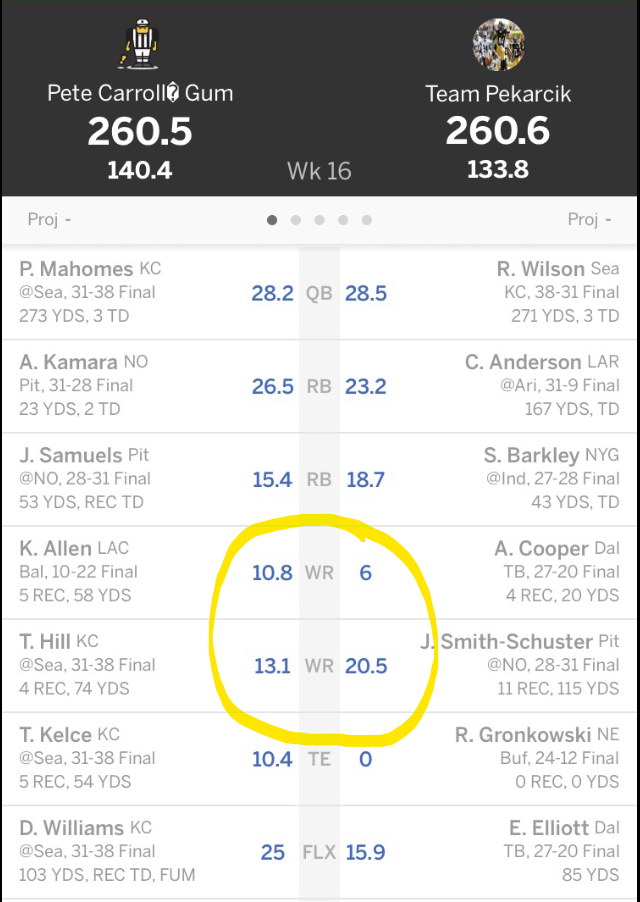

The below image shows the top 2021 WR performers. 

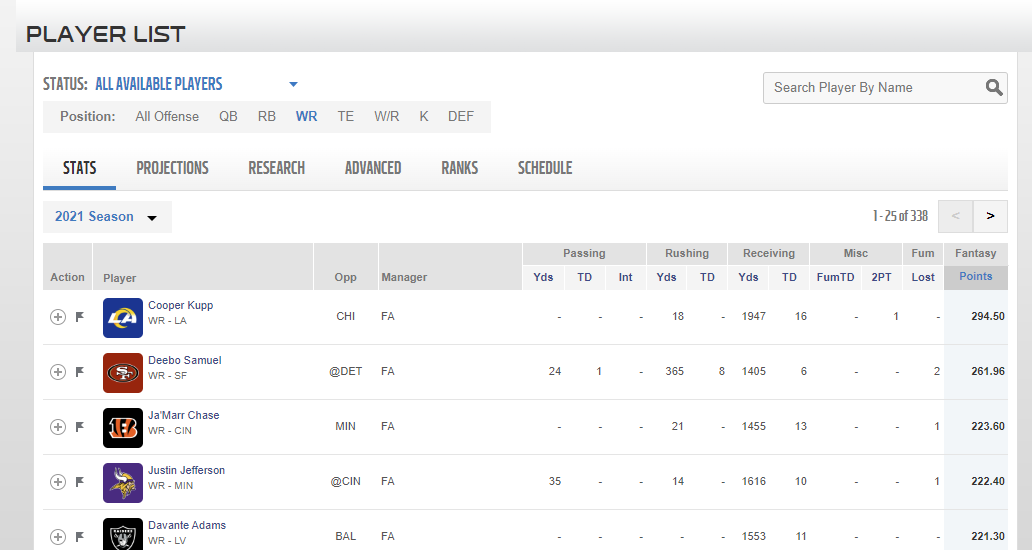

The scoring system is very simple and takes into accounts only a few data points. The way to predict player performance however, is much more complex. There are hundreds of features to choose from when getting into the analysis. Below is a list of them which I will experience with in my neural network.

- Number of targets per game
- Number of catches per game
- Average depth of targets
- Average yards after catch
- Numbers of games played
- Total number of yards/game
- Player age
- Carries
- Touchdown passes caught
- Fumbles

I've reached out to the NFL directly to try and get access to their developer API to get the data but they charge a large annual fee.

https://developer.nfl.com/

I was thinking of scrapping the data directly from the web (plenty of available resources) but luckily there was an existing free API that got me what I needed.

https://pypi.org/project/nfl-data-py/


In [190]:
from datetime import datetime, date
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import  train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [191]:
# Loading historical player stats and fantasy points per year

sea_l = [year for year in range(2000,2022)]
drop_l = ['season_type', 'interceptions', 'sacks', 'sack_yards','sack_fumbles', 'sack_fumbles_lost',
         'passing_first_downs', 'passing_epa', 'dakota', 'special_teams_tds', 'fantasy_points_ppr']

df = nfl.import_seasonal_data(sea_l)
df_stats = df[df['season_type'] == 'REG']
df_stats = df_stats.drop(columns=drop_l)
df_stats.head(5)

,player_id,season,completions,attempts,passing_yards,passing_tds,passing_air_yards,passing_yards_after_catch,passing_2pt_conversions,carries,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0000003,2000,0,0,0.0,0,0.0,0.0,0,1,...,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002418
1,00-0000007,2000,0,0,0.0,0,0.0,0.0,0,16,...,NaN,NaN,0.034230,0.0,0.043478,0.041667,0.017115,0.027384,0.197183,0.053758
2,00-0000007,2001,0,0,0.0,0,0.0,0.0,0,11,...,NaN,NaN,0.064838,0.0,0.095238,0.083333,0.032419,0.051870,0.412698,0.054108
3,00-0000007,2003,0,0,0.0,0,0.0,0.0,0,18,...,NaN,NaN,0.024091,0.0,0.027273,0.025424,0.012046,0.019273,0.139241,0.021780
4,00-0000007,2004,0,0,0.0,0,0.0,0.0,0,13,...,NaN,NaN,0.007149,0.0,0.000000,0.000000,0.003574,0.005719,0.051136,0.018839


In [192]:
# Loading NFL historical rosters to be able to filter on WR and get players AGE which will be an important feature
# Some data cleaning needed to be done here as well. Notably missing DOB which caused issues on later transforms

df1 = nfl.import_rosters(sea_l)

df_players = pd.DataFrame()
df_players['player_id'] = df1['player_id']
df_players['birth_date'] = df1['birth_date']
df_players['position'] = df1['position']
df_players['name'] = df1['first_name'] + ' ' + df1['last_name']

df_players.drop_duplicates(subset ="player_id",keep = 'first', inplace = True)

# Some players DOB was missing everywhere "had to look it up on google"
df_players.loc[df_players.name == 'Brandon Marshall', 'birth_date'] = '1984-03-23'
df_players.loc[df_players.name == 'Brandon LaFell', 'birth_date'] = '1986-11-04'
df_players.loc[df_players.name == 'Eric Decker', 'birth_date'] = '1987-03-15'
df_players.loc[df_players.player_id == '00-0027793', 'birth_date'] = '1988-07-10'
df_players.loc[df_players.player_id == '00-0036900', 'birth_date'] = '2000-03-01'
df_players.loc[df_players.name == 'Dez Bryant', 'birth_date'] = '1988-11-04'
df_players.loc[df_players.name == 'Kelvin Benjamin', 'birth_date'] = '1991-02-05'
df_players.loc[df_players.name == 'Justin Jefferson', 'birth_date'] = '1999-01-16'
df_players.loc[df_players.name == 'Michael Crabtree', 'birth_date'] = '1987-09-14'

placeh = pd.to_datetime('1900-01-01')
df_players['birth_date'] = df_players['birth_date'].fillna(placeh)

df_players.tail(5)

,player_id,birth_date,position,name
2678,00-0036703,1900-01-01,SPEC,Brian Johnson
2684,00-0036474,1900-01-01,TE,Sammis Reyes
2685,00-0036628,1900-01-01,TE,John Bates
2694,00-0036626,1900-01-01,WR,Dyami Brown
2695,00-0036671,1900-01-01,WR,Dax Milne


In [193]:
# Merge the players and stats dataframe to get ALL the data required in one place. Filter on 'WR' only

df_full = pd.merge(df_stats,df_players,on = 'player_id',how='left')
df_wr_full = df_full[df_full.position == 'WR']
df_wr_full[df_wr_full['name'] == 'Antonio Brown']

,player_id,season,completions,attempts,passing_yards,passing_tds,passing_air_yards,passing_yards_after_catch,passing_2pt_conversions,carries,...,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh,birth_date,position,name
3834,00-0021425,2003,0,0,0.0,0,0.0,0.0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018731,1900-01-01,WR,Antonio Brown
3835,00-0021425,2005,0,0,0.0,0,0.0,0.0,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032196,1900-01-01,WR,Antonio Brown
7980,00-0027793,2010,0,0,0.0,0,0.0,0.0,0,0,...,0.000000,0.114943,0.104167,0.044439,0.071102,0.684426,0.060653,1988-07-10,WR,Antonio Brown
7981,00-0027793,2011,0,0,0.0,0,0.0,0.0,0,7,...,0.095238,0.257919,0.243802,0.175475,0.223617,2.055659,0.146738,1988-07-10,WR,Antonio Brown
7982,00-0027793,2012,0,2,0.0,0,41.0,0.0,0,7,...,0.192308,0.247126,0.240000,0.209981,0.220585,1.678038,0.147209,1988-07-10,WR,Antonio Brown
7983,00-0027793,2013,1,1,15.0,0,11.0,4.0,0,7,...,0.285714,0.338164,0.331915,0.316917,0.335638,2.558020,0.223074,1988-07-10,WR,Antonio Brown
7984,00-0027793,2014,2,2,20.0,1,9.0,11.0,0,4,...,0.393939,0.349794,0.355072,0.366872,0.350631,2.774510,0.233661,1988-07-10,WR,Antonio Brown
7985,00-0027793,2015,0,0,0.0,0,0.0,0.0,0,3,...,0.384615,0.405797,0.403433,0.382478,0.381195,3.108475,0.246840,1988-07-10,WR,Antonio Brown
7986,00-0027793,2016,0,0,0.0,0,0.0,0.0,0,3,...,0.400000,0.328205,0.337778,0.356585,0.330537,2.296959,0.211916,1988-07-10,WR,Antonio Brown
7987,00-0027793,2017,0,0,0.0,0,0.0,0.0,0,0,...,0.346154,0.362245,0.360360,0.361452,0.370632,2.876173,0.231126,1988-07-10,WR,Antonio Brown


In [194]:
# Still have some missing DOB, needed to get the info from another source

df_dob = pd.read_csv('C:/Users/phili/Onedrive/Desktop/players_dat.txt',header=1)
df_dob1 = df_dob[(df_dob['Rk'] != 'Rk') & (df_dob['Rk'].notnull())]
s1 = []

# Clean players name from the file
for i in df_dob1['Player']:
    s1.append(i.split('\\')[0].split('*')[0])
    
df_dob1['name'] = s1

df_dob2 = pd.DataFrame()
df_dob2['name'] = df_dob1['name']
df_dob2['season'] = df_dob1['Year']
df_dob2['age'] = df_dob1['Age']

df_dob2 = df_dob2.reset_index(drop=True)
df_dob2['season'] = df_dob2['season'].astype(str).astype(int)

df_dob2

,name,season,age
0,Jerry Rice,1987,25
1,Wes Chandler,1982,26
2,Jerry Rice,1995,33
3,Randy Moss,2007,30
4,Anthony Allen,1987,28
...,...,...,...
6456,Devon Wylie,2014,26
6457,Milton Wynn,2002,24
6458,Craig Yeast,2001,25
6459,Mike Young,1994,32


In [204]:
# Data cleaning continues
# One source had the player age, the other the DOB. Create a function to extract the player age from current SEASON and
# DOB.

def age(old,new):
    old = old
    new = new
    return -(new.year - old.year - ((new.month, new.day) < (old.month,old.day)))

df_conv = pd.merge(df_wr_full,df_dob2,on=['name','season'],how='left')
df_conv = df_conv.drop_duplicates(subset=['player_id','season'])
df_conv['season'] = pd.to_datetime(df_conv['season'], format='%Y')

true_age = []   

for row in df_conv.iterrows():
    true_age.append(age(row[1][1],row[1][47]))

df_conv['age2'] = true_age
df_wr = df_conv

final_l = []

for row in df_wr.iterrows():
    if row[1][51] > 80:
        final_l.append(row[1][50])
    else:
        final_l.append(row[1][51])
        
# More data cleaning
        
df_wr['fin'] = final_l
df_wr['age'] = df_wr['fin']
df_wr = df_wr.drop(columns=['age2','fin','birth_date'])
df_wr = df_wr[df_wr['age'].notna()]
df_wr = df_wr.reset_index(drop=True)
df_wr['season'] = df_wr['season'].dt.year.astype(str).astype(int)
df_wr['age'] = df_wr['age'].astype(str).astype(int)
df_wr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_wr = df_wr.fillna(0)

Text(0, 0.5, 'Fantasy Points')

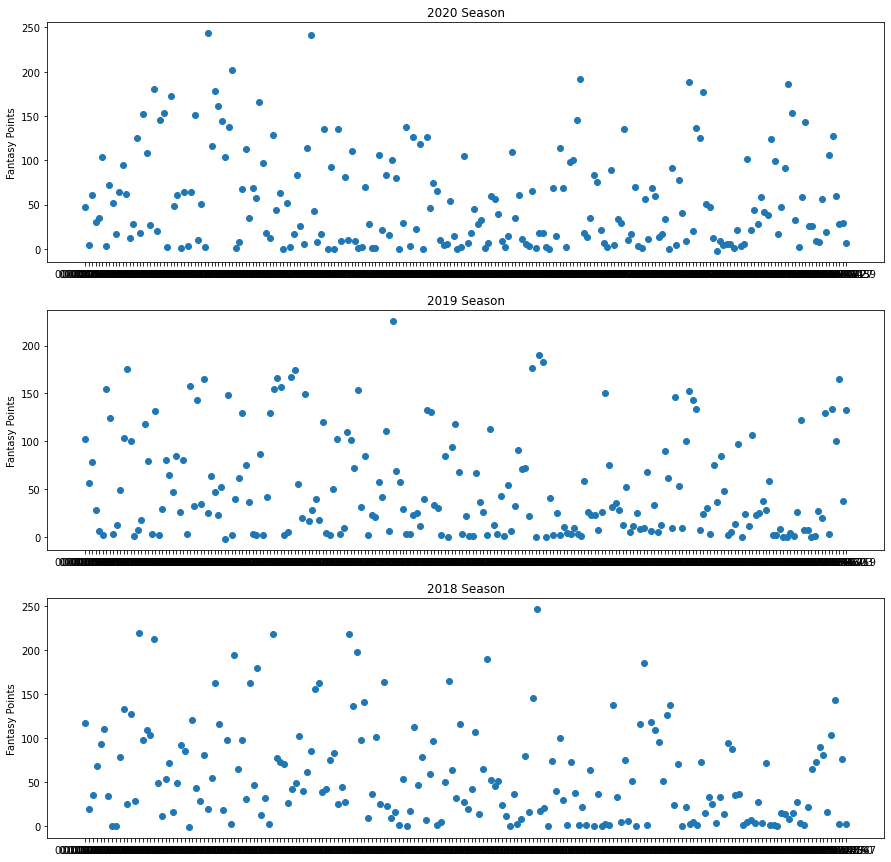

In [207]:
# Distribution of players points per seasons

x4 = df_wr[df_wr['season'] == 2020]['player_id']
y4 = df_wr[df_wr['season'] == 2020]['fantasy_points']

x5 = df_wr[df_wr['season'] == 2019]['player_id']
y5 = df_wr[df_wr['season'] == 2019]['fantasy_points']

x6 = df_wr[df_wr['season'] == 2018]['player_id']
y6 = df_wr[df_wr['season'] == 2018]['fantasy_points']

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].scatter(x4,y4)
ax[0].set_ylabel('Fantasy Points')
ax[0].title.set_text('2020 Season')
ax[1].scatter(x5,y5)
ax[1].set_ylabel('Fantasy Points')
ax[1].title.set_text('2019 Season')
ax[2].scatter(x6,y6)
ax[2].title.set_text('2018 Season')
ax[2].set_ylabel('Fantasy Points')

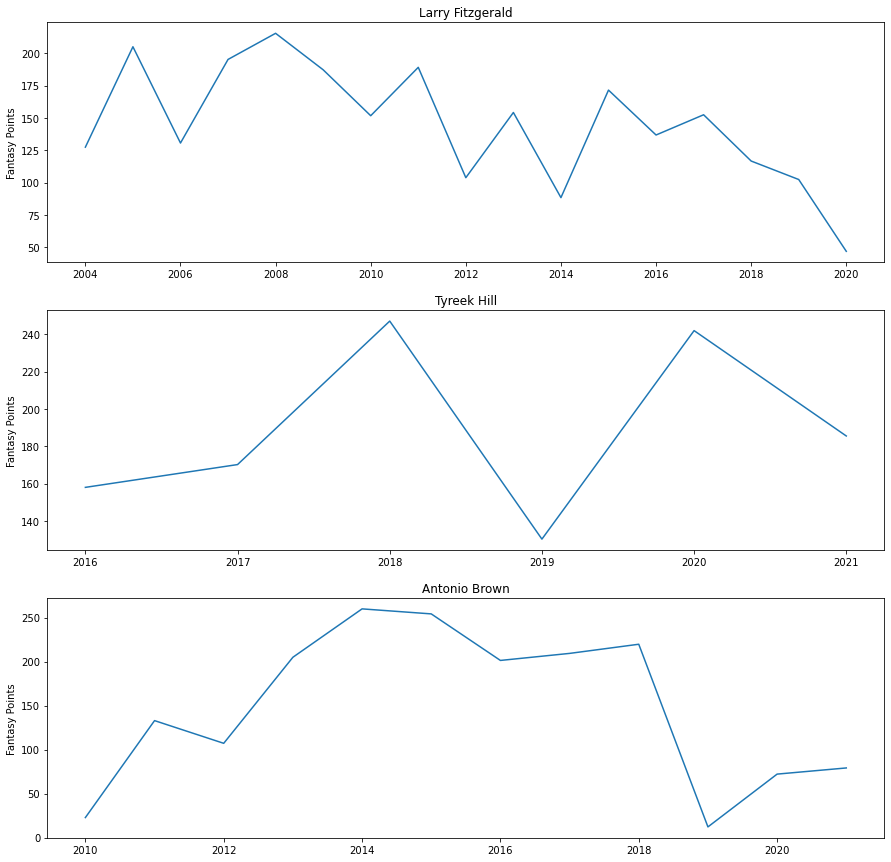

In [203]:
# Display of fantasy points (dependent var) per year and how it swings even for good players

x1 = df_wr[df_wr['name'] == 'Larry Fitzgerald']['season']
y1 = df_wr[df_wr['name'] == 'Larry Fitzgerald']['fantasy_points']

x2 = df_wr[df_wr['name'] == 'Tyreek Hill']['season']
y2 = df_wr[df_wr['name'] == 'Tyreek Hill']['fantasy_points']

x3 = df_wr[df_wr['player_id'] == '00-0027793']['season']
y3 = df_wr[df_wr['player_id'] == '00-0027793']['fantasy_points']

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(x1,y1)
ax[0].set_ylabel('Fantasy Points')
ax[0].title.set_text('Larry Fitzgerald')
ax[1].plot(x2,y2)
ax[1].set_ylabel('Fantasy Points')
ax[1].title.set_text('Tyreek Hill')
ax[2].plot(x3,y3)
ax[2].title.set_text('Antonio Brown')
ax[2].set_ylabel('Fantasy Points')

plt.show()

In [208]:
# Just saving my raw data in case something goes wrong with the API while i'm experimenting with my project

df_wr.to_csv("C:/Users/phili/OneDrive/Desktop/df_wr.txt")
df_wr_full.to_csv("C:/Users/phili/OneDrive/Desktop/df_wr_full.txt")

In [210]:
# Complete list of features to predict player performance

for i in df_wr.columns:
    print(i)

player_id
season
completions
attempts
passing_yards
passing_tds
passing_air_yards
passing_yards_after_catch
passing_2pt_conversions
carries
rushing_yards
rushing_tds
rushing_fumbles
rushing_fumbles_lost
rushing_first_downs
rushing_epa
rushing_2pt_conversions
receptions
targets
receiving_yards
receiving_tds
receiving_fumbles
receiving_fumbles_lost
receiving_air_yards
receiving_yards_after_catch
receiving_first_downs
receiving_epa
receiving_2pt_conversions
fantasy_points
pacr
racr
target_share
air_yards_share
wopr_x
games
tgt_sh
ay_sh
yac_sh
wopr_y
ry_sh
rtd_sh
rfd_sh
rtdfd_sh
dom
w8dom
yptmpa
ppr_sh
position
name
age


In [212]:
# Excluding 2021 data points from X, these are our validation/prediction data points.

X = df_wr[df_wr['season'] != 2021]
y = X['fantasy_points']
X = X.drop(columns=['player_id','position','name','fantasy_points'])

# Tried removing more features when running the neural net to see if it would affect it's performance/accuracy

# X = X.drop(columns=['player_id','position','name','fantasy_points',
#                    'completions', 'attempts', 'passing_yards',
#                    'passing_tds', 'passing_air_yards', 'passing_yards_after_catch',
#                    'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds',
#                    'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs',
#                    'rushing_epa', 'rushing_2pt_conversions'])

# Using sklearn StandardScaler function to standardise our data. We have a large amount of features, each of which 
# are on different scales. Results would not make any sense if we didn't standaradize the input.

X = StandardScaler().fit_transform(X)

# I played with test size during the experimental phases, 0.25 seemed like a good ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Training data length: {len(X_train)}")

print(f"Testing data shape: {X_test.shape}")
print(f"Testing data length: {len(X_test)}")

Training data shape: (2307, 46)
Training data length: 2307
Testing data shape: (770, 46)
Testing data length: 770


In [246]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(X_train))
# print(normalizer.mean.numpy())

# first = np.array(X_train[:1])

# with np.printoptions(precision=2, suppress=True):
#     print('First example:', first)
#     print()
#     print('Normalized:', normalizer(first).numpy())

# The neural network

The next few cells will show the configuration of the neural network as well as the training and the results I've achieved. A lot of iterations were tried to find the best possible configuration for the model. Some parameters I've played with include :
- Kernel initializer
- Activation function for input, dense and output layers
- Batch normalization
- Loss functions
- Optimizers
- Dropouts
- Number of features used
- Number of dense layers
- Number of units (neurons) per layers

I've even tried to convert my input into a 46x46x1 matrix to used Conv2D layers

In [241]:
# The model
model = tf.keras.Sequential()
model.add(Dense(28, input_shape=(46,), kernel_initializer='normal',activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae","mse"])

In [ ]:
# create model
model = tf.keras.Sequential()
# model.add(normalizer)
model.add(Dense(46, input_shape=(46,), kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss="mae", optimizer="adam", metrics=["mae","mse"])

In [242]:
from keras import backend as K

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 28)                1316      
                                                                 
 dense_88 (Dense)            (None, 64)                1856      
                                                                 
 dense_89 (Dense)            (None, 128)               8320      
                                                                 
 dense_90 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_91 (Dense)            (None, 1)                 65        
                                                                 
Total params: 19,813
Trainable params: 19,813
Non-tra

In [243]:
# es = EarlyStopping(monitor='val_loss', patience=200)
K.set_value(model.optimizer.learning_rate, 0.001) #0.001 = DEFAULT
epochs = 1000
# history = model.fit(X_train, y_train, batch_size=10, validation_split=0.1, epochs=epochs, callbacks=[es])
history = model.fit(X_train, y_train, batch_size=10, validation_split=0.1, epochs=epochs)

Epoch 1/1000
208/208 [==============================] - 1s 1ms/step - loss: 2056.5015 - mae: 28.7752 - mse: 2056.5015 - val_loss: 107.2500 - val_mae: 8.0062 - val_mse: 107.2500
Epoch 2/1000
208/208 [==============================] - 0s 940us/step - loss: 406.6456 - mae: 13.3221 - mse: 406.6456 - val_loss: 90.0135 - val_mae: 6.4298 - val_mse: 90.0135
Epoch 3/1000
208/208 [==============================] - 0s 988us/step - loss: 419.9443 - mae: 12.6311 - mse: 419.9443 - val_loss: 69.1943 - val_mae: 5.6998 - val_mse: 69.1943
Epoch 4/1000
208/208 [==============================] - 0s 862us/step - loss: 347.6502 - mae: 11.7287 - mse: 347.6502 - val_loss: 62.2252 - val_mae: 5.2860 - val_mse: 62.2252
Epoch 5/1000
208/208 [==============================] - 0s 795us/step - loss: 381.7683 - mae: 12.0063 - mse: 381.7683 - val_loss: 37.3849 - val_mae: 4.4837 - val_mse: 37.3849
Epoch 6/1000
208/208 [==============================] - 0s 761us/step - loss: 324.9602 - mae: 11.4377 - mse: 324.9602 - val

208/208 [==============================] - 0s 732us/step - loss: 281.3901 - mae: 10.2887 - mse: 281.3901 - val_loss: 49.4141 - val_mae: 4.6548 - val_mse: 49.4141
Epoch 48/1000
208/208 [==============================] - 0s 739us/step - loss: 289.3802 - mae: 10.3355 - mse: 289.3802 - val_loss: 47.0833 - val_mae: 4.9379 - val_mse: 47.0833
Epoch 49/1000
208/208 [==============================] - 0s 732us/step - loss: 307.7084 - mae: 10.5008 - mse: 307.7084 - val_loss: 14.4816 - val_mae: 2.6502 - val_mse: 14.4816
Epoch 50/1000
208/208 [==============================] - 0s 742us/step - loss: 268.9779 - mae: 9.9212 - mse: 268.9779 - val_loss: 33.8459 - val_mae: 3.9709 - val_mse: 33.8459
Epoch 51/1000
208/208 [==============================] - 0s 737us/step - loss: 291.5528 - mae: 10.2345 - mse: 291.5528 - val_loss: 24.9723 - val_mae: 3.5876 - val_mse: 24.9723
Epoch 52/1000
208/208 [==============================] - 0s 737us/step - loss: 258.5569 - mae: 9.7346 - mse: 258.5569 - val_loss: 25.16

Epoch 94/1000
208/208 [==============================] - 0s 728us/step - loss: 265.7197 - mae: 9.7135 - mse: 265.7197 - val_loss: 28.9843 - val_mae: 3.6286 - val_mse: 28.9843
Epoch 95/1000
208/208 [==============================] - 0s 732us/step - loss: 280.6816 - mae: 9.8512 - mse: 280.6816 - val_loss: 22.0136 - val_mae: 3.0339 - val_mse: 22.0136
Epoch 96/1000
208/208 [==============================] - 0s 728us/step - loss: 279.7286 - mae: 9.8691 - mse: 279.7286 - val_loss: 36.3750 - val_mae: 4.3615 - val_mse: 36.3750
Epoch 97/1000
208/208 [==============================] - 0s 728us/step - loss: 276.7296 - mae: 9.7977 - mse: 276.7296 - val_loss: 10.3892 - val_mae: 2.2294 - val_mse: 10.3892
Epoch 98/1000
208/208 [==============================] - 0s 728us/step - loss: 233.6564 - mae: 9.2941 - mse: 233.6564 - val_loss: 13.4011 - val_mae: 2.3997 - val_mse: 13.4011
Epoch 99/1000
208/208 [==============================] - 0s 723us/step - loss: 271.6273 - mae: 9.8891 - mse: 271.6273 - val_l

208/208 [==============================] - 0s 737us/step - loss: 236.0902 - mae: 9.2076 - mse: 236.0902 - val_loss: 21.2760 - val_mae: 3.0739 - val_mse: 21.2760
Epoch 141/1000
208/208 [==============================] - 0s 742us/step - loss: 261.4749 - mae: 9.4288 - mse: 261.4749 - val_loss: 16.9173 - val_mae: 2.5338 - val_mse: 16.9173
Epoch 142/1000
208/208 [==============================] - 0s 747us/step - loss: 255.1756 - mae: 9.4860 - mse: 255.1756 - val_loss: 11.5002 - val_mae: 2.1156 - val_mse: 11.5002
Epoch 143/1000
208/208 [==============================] - 0s 733us/step - loss: 243.3273 - mae: 9.1135 - mse: 243.3273 - val_loss: 58.2975 - val_mae: 4.9420 - val_mse: 58.2975
Epoch 144/1000
208/208 [==============================] - 0s 732us/step - loss: 237.3328 - mae: 9.1234 - mse: 237.3328 - val_loss: 13.9097 - val_mae: 2.5396 - val_mse: 13.9097
Epoch 145/1000
208/208 [==============================] - 0s 737us/step - loss: 244.2085 - mae: 9.3249 - mse: 244.2085 - val_loss: 15.5

Epoch 187/1000
208/208 [==============================] - 0s 737us/step - loss: 222.4425 - mae: 8.9543 - mse: 222.4425 - val_loss: 22.1907 - val_mae: 3.2475 - val_mse: 22.1907
Epoch 188/1000
208/208 [==============================] - 0s 737us/step - loss: 234.4495 - mae: 8.9238 - mse: 234.4495 - val_loss: 24.9936 - val_mae: 3.4359 - val_mse: 24.9936
Epoch 189/1000
208/208 [==============================] - 0s 747us/step - loss: 236.7352 - mae: 9.0455 - mse: 236.7352 - val_loss: 13.4885 - val_mae: 1.9756 - val_mse: 13.4885
Epoch 190/1000
208/208 [==============================] - 0s 735us/step - loss: 230.2486 - mae: 9.0462 - mse: 230.2486 - val_loss: 14.8897 - val_mae: 2.4624 - val_mse: 14.8897
Epoch 191/1000
208/208 [==============================] - 0s 739us/step - loss: 237.6758 - mae: 9.0140 - mse: 237.6758 - val_loss: 9.9607 - val_mae: 2.0785 - val_mse: 9.9607
Epoch 192/1000
208/208 [==============================] - 0s 752us/step - loss: 219.1232 - mae: 8.8072 - mse: 219.1232 - v

208/208 [==============================] - 0s 742us/step - loss: 233.7967 - mae: 8.9966 - mse: 233.7967 - val_loss: 25.7488 - val_mae: 3.4782 - val_mse: 25.7488
Epoch 234/1000
208/208 [==============================] - 0s 737us/step - loss: 212.3495 - mae: 8.4157 - mse: 212.3495 - val_loss: 42.1152 - val_mae: 4.3787 - val_mse: 42.1152
Epoch 235/1000
208/208 [==============================] - 0s 727us/step - loss: 220.7537 - mae: 8.7748 - mse: 220.7537 - val_loss: 8.9448 - val_mae: 1.8588 - val_mse: 8.9448
Epoch 236/1000
208/208 [==============================] - 0s 732us/step - loss: 210.8168 - mae: 8.5261 - mse: 210.8168 - val_loss: 18.7425 - val_mae: 2.6921 - val_mse: 18.7425
Epoch 237/1000
208/208 [==============================] - 0s 732us/step - loss: 219.6127 - mae: 8.7295 - mse: 219.6127 - val_loss: 46.9586 - val_mae: 4.5340 - val_mse: 46.9586
Epoch 238/1000
208/208 [==============================] - 0s 732us/step - loss: 215.5968 - mae: 8.5364 - mse: 215.5968 - val_loss: 19.349

Epoch 280/1000
208/208 [==============================] - 0s 718us/step - loss: 190.0768 - mae: 8.3159 - mse: 190.0768 - val_loss: 16.6186 - val_mae: 2.6776 - val_mse: 16.6186
Epoch 281/1000
208/208 [==============================] - 0s 930us/step - loss: 207.4956 - mae: 8.4224 - mse: 207.4956 - val_loss: 29.5960 - val_mae: 3.9513 - val_mse: 29.5960
Epoch 282/1000
208/208 [==============================] - 0s 862us/step - loss: 197.7927 - mae: 8.3301 - mse: 197.7927 - val_loss: 12.5296 - val_mae: 2.4062 - val_mse: 12.5296
Epoch 283/1000
208/208 [==============================] - 0s 935us/step - loss: 204.1525 - mae: 8.4540 - mse: 204.1525 - val_loss: 52.0243 - val_mae: 4.9565 - val_mse: 52.0243
Epoch 284/1000
208/208 [==============================] - 0s 752us/step - loss: 202.2293 - mae: 8.4770 - mse: 202.2293 - val_loss: 12.9557 - val_mae: 2.4421 - val_mse: 12.9557
Epoch 285/1000
208/208 [==============================] - 0s 737us/step - loss: 202.1296 - mae: 8.4392 - mse: 202.1296 -

208/208 [==============================] - 0s 973us/step - loss: 196.7343 - mae: 8.2882 - mse: 196.7343 - val_loss: 39.5533 - val_mae: 4.0789 - val_mse: 39.5533
Epoch 327/1000
208/208 [==============================] - 0s 877us/step - loss: 214.2616 - mae: 8.5639 - mse: 214.2616 - val_loss: 11.0681 - val_mae: 2.0420 - val_mse: 11.0681
Epoch 328/1000
208/208 [==============================] - 0s 915us/step - loss: 192.4715 - mae: 8.2981 - mse: 192.4715 - val_loss: 10.1575 - val_mae: 2.0818 - val_mse: 10.1575
Epoch 329/1000
208/208 [==============================] - 0s 949us/step - loss: 184.1679 - mae: 8.0423 - mse: 184.1679 - val_loss: 24.8594 - val_mae: 3.3010 - val_mse: 24.8594
Epoch 330/1000
208/208 [==============================] - 0s 872us/step - loss: 201.3259 - mae: 8.4674 - mse: 201.3259 - val_loss: 33.7202 - val_mae: 3.7023 - val_mse: 33.7202
Epoch 331/1000
208/208 [==============================] - 0s 862us/step - loss: 184.0020 - mae: 8.0258 - mse: 184.0020 - val_loss: 19.7

208/208 [==============================] - 0s 718us/step - loss: 177.6801 - mae: 7.9893 - mse: 177.6801 - val_loss: 25.2941 - val_mae: 3.3739 - val_mse: 25.2941
Epoch 373/1000
208/208 [==============================] - 0s 723us/step - loss: 189.8788 - mae: 8.1081 - mse: 189.8788 - val_loss: 14.0564 - val_mae: 2.7873 - val_mse: 14.0564
Epoch 374/1000
208/208 [==============================] - 0s 713us/step - loss: 182.1216 - mae: 7.9691 - mse: 182.1217 - val_loss: 12.6765 - val_mae: 2.1356 - val_mse: 12.6765
Epoch 375/1000
208/208 [==============================] - 0s 723us/step - loss: 215.5548 - mae: 8.5143 - mse: 215.5548 - val_loss: 11.4715 - val_mae: 2.1508 - val_mse: 11.4715
Epoch 376/1000
208/208 [==============================] - 0s 723us/step - loss: 157.6253 - mae: 7.6879 - mse: 157.6253 - val_loss: 10.8882 - val_mae: 2.3189 - val_mse: 10.8882
Epoch 377/1000
208/208 [==============================] - 0s 723us/step - loss: 179.9576 - mae: 8.0461 - mse: 179.9576 - val_loss: 13.8

Epoch 419/1000
208/208 [==============================] - 0s 781us/step - loss: 185.4922 - mae: 7.9935 - mse: 185.4922 - val_loss: 22.9772 - val_mae: 3.0224 - val_mse: 22.9772
Epoch 420/1000
208/208 [==============================] - 0s 824us/step - loss: 165.8498 - mae: 7.7255 - mse: 165.8498 - val_loss: 73.4640 - val_mae: 5.3653 - val_mse: 73.4640
Epoch 421/1000
208/208 [==============================] - 0s 728us/step - loss: 182.2620 - mae: 8.0431 - mse: 182.2620 - val_loss: 49.3017 - val_mae: 4.3394 - val_mse: 49.3017
Epoch 422/1000
208/208 [==============================] - 0s 723us/step - loss: 196.1877 - mae: 8.2266 - mse: 196.1877 - val_loss: 39.7956 - val_mae: 4.1976 - val_mse: 39.7956
Epoch 423/1000
208/208 [==============================] - 0s 728us/step - loss: 174.7193 - mae: 8.0225 - mse: 174.7193 - val_loss: 17.6479 - val_mae: 2.5771 - val_mse: 17.6479
Epoch 424/1000
208/208 [==============================] - 0s 732us/step - loss: 200.1797 - mae: 8.1942 - mse: 200.1797 -

208/208 [==============================] - 0s 752us/step - loss: 169.3209 - mae: 7.8775 - mse: 169.3209 - val_loss: 10.1298 - val_mae: 2.2605 - val_mse: 10.1298
Epoch 466/1000
208/208 [==============================] - 0s 752us/step - loss: 170.6392 - mae: 7.8961 - mse: 170.6392 - val_loss: 7.3289 - val_mae: 1.9694 - val_mse: 7.3289
Epoch 467/1000
208/208 [==============================] - 0s 781us/step - loss: 169.4042 - mae: 7.8348 - mse: 169.4042 - val_loss: 35.3566 - val_mae: 4.0715 - val_mse: 35.3566
Epoch 468/1000
208/208 [==============================] - 0s 752us/step - loss: 173.3566 - mae: 7.9426 - mse: 173.3566 - val_loss: 7.7770 - val_mae: 2.0265 - val_mse: 7.7770
Epoch 469/1000
208/208 [==============================] - 0s 742us/step - loss: 148.2820 - mae: 7.5322 - mse: 148.2820 - val_loss: 17.7126 - val_mae: 2.8477 - val_mse: 17.7126
Epoch 470/1000
208/208 [==============================] - 0s 728us/step - loss: 157.7805 - mae: 7.5809 - mse: 157.7805 - val_loss: 9.3835 -

Epoch 512/1000
208/208 [==============================] - 0s 877us/step - loss: 152.2865 - mae: 7.6880 - mse: 152.2865 - val_loss: 11.3629 - val_mae: 2.6259 - val_mse: 11.3629
Epoch 513/1000
208/208 [==============================] - 0s 925us/step - loss: 151.0622 - mae: 7.6042 - mse: 151.0622 - val_loss: 17.5509 - val_mae: 2.8244 - val_mse: 17.5509
Epoch 514/1000
208/208 [==============================] - 0s 834us/step - loss: 166.3687 - mae: 7.6317 - mse: 166.3687 - val_loss: 39.6456 - val_mae: 4.3711 - val_mse: 39.6456
Epoch 515/1000
208/208 [==============================] - 0s 752us/step - loss: 176.7274 - mae: 8.1419 - mse: 176.7274 - val_loss: 10.3688 - val_mae: 2.1273 - val_mse: 10.3688
Epoch 516/1000
208/208 [==============================] - 0s 732us/step - loss: 176.3118 - mae: 8.0267 - mse: 176.3118 - val_loss: 14.2526 - val_mae: 2.4193 - val_mse: 14.2526
Epoch 517/1000
208/208 [==============================] - 0s 809us/step - loss: 144.3003 - mae: 7.5457 - mse: 144.3003 -

Epoch 559/1000
208/208 [==============================] - 0s 781us/step - loss: 166.4678 - mae: 7.8242 - mse: 166.4678 - val_loss: 44.9780 - val_mae: 4.6149 - val_mse: 44.9780
Epoch 560/1000
208/208 [==============================] - 0s 747us/step - loss: 156.5721 - mae: 7.6890 - mse: 156.5721 - val_loss: 7.0277 - val_mae: 1.8450 - val_mse: 7.0277
Epoch 561/1000
208/208 [==============================] - 0s 834us/step - loss: 153.7741 - mae: 7.5501 - mse: 153.7741 - val_loss: 14.5450 - val_mae: 2.5901 - val_mse: 14.5450
Epoch 562/1000
208/208 [==============================] - 0s 785us/step - loss: 162.3042 - mae: 7.7440 - mse: 162.3042 - val_loss: 25.8829 - val_mae: 3.4163 - val_mse: 25.8829
Epoch 563/1000
208/208 [==============================] - 0s 752us/step - loss: 170.5044 - mae: 7.7869 - mse: 170.5044 - val_loss: 21.9324 - val_mae: 3.0751 - val_mse: 21.9324
Epoch 564/1000
208/208 [==============================] - 0s 771us/step - loss: 156.4459 - mae: 7.8090 - mse: 156.4459 - v

208/208 [==============================] - 0s 743us/step - loss: 151.1010 - mae: 7.7174 - mse: 151.1010 - val_loss: 12.1094 - val_mae: 2.7014 - val_mse: 12.1094
Epoch 606/1000
208/208 [==============================] - 0s 747us/step - loss: 143.1791 - mae: 7.4556 - mse: 143.1791 - val_loss: 11.3126 - val_mae: 2.2806 - val_mse: 11.3126
Epoch 607/1000
208/208 [==============================] - 0s 732us/step - loss: 160.5953 - mae: 7.6713 - mse: 160.5953 - val_loss: 9.0563 - val_mae: 2.0517 - val_mse: 9.0563
Epoch 608/1000
208/208 [==============================] - 0s 732us/step - loss: 160.7034 - mae: 7.7709 - mse: 160.7034 - val_loss: 8.2054 - val_mae: 2.1590 - val_mse: 8.2054
Epoch 609/1000
208/208 [==============================] - 0s 737us/step - loss: 149.8314 - mae: 7.5691 - mse: 149.8314 - val_loss: 8.8697 - val_mae: 2.0189 - val_mse: 8.8697
Epoch 610/1000
208/208 [==============================] - 0s 742us/step - loss: 146.1293 - mae: 7.5859 - mse: 146.1293 - val_loss: 18.3924 - 

Epoch 652/1000
208/208 [==============================] - 0s 771us/step - loss: 154.1302 - mae: 7.7385 - mse: 154.1302 - val_loss: 17.2714 - val_mae: 3.0039 - val_mse: 17.2714
Epoch 653/1000
208/208 [==============================] - 0s 747us/step - loss: 140.1740 - mae: 7.5800 - mse: 140.1740 - val_loss: 9.0187 - val_mae: 2.0200 - val_mse: 9.0187
Epoch 654/1000
208/208 [==============================] - 0s 752us/step - loss: 140.0703 - mae: 7.5601 - mse: 140.0703 - val_loss: 23.3296 - val_mae: 3.5561 - val_mse: 23.3296
Epoch 655/1000
208/208 [==============================] - 0s 744us/step - loss: 161.2637 - mae: 7.6397 - mse: 161.2637 - val_loss: 15.5256 - val_mae: 3.1488 - val_mse: 15.5256
Epoch 656/1000
208/208 [==============================] - 0s 747us/step - loss: 131.0233 - mae: 7.3317 - mse: 131.0233 - val_loss: 29.3138 - val_mae: 4.1089 - val_mse: 29.3138
Epoch 657/1000
208/208 [==============================] - 0s 745us/step - loss: 148.6386 - mae: 7.4606 - mse: 148.6386 - v

Epoch 699/1000
208/208 [==============================] - 0s 752us/step - loss: 134.7314 - mae: 7.4200 - mse: 134.7314 - val_loss: 11.2034 - val_mae: 2.5024 - val_mse: 11.2034
Epoch 700/1000
208/208 [==============================] - 0s 752us/step - loss: 160.9412 - mae: 7.7860 - mse: 160.9412 - val_loss: 6.7645 - val_mae: 1.7852 - val_mse: 6.7645
Epoch 701/1000
208/208 [==============================] - 0s 749us/step - loss: 151.9365 - mae: 7.7601 - mse: 151.9365 - val_loss: 9.8388 - val_mae: 2.3476 - val_mse: 9.8388
Epoch 702/1000
208/208 [==============================] - 0s 761us/step - loss: 153.6246 - mae: 7.7589 - mse: 153.6246 - val_loss: 23.2757 - val_mae: 3.0769 - val_mse: 23.2757
Epoch 703/1000
208/208 [==============================] - 0s 756us/step - loss: 153.2195 - mae: 7.6546 - mse: 153.2195 - val_loss: 20.7558 - val_mae: 3.1310 - val_mse: 20.7558
Epoch 704/1000
208/208 [==============================] - 0s 747us/step - loss: 146.9646 - mae: 7.7006 - mse: 146.9646 - val

Epoch 746/1000
208/208 [==============================] - 0s 761us/step - loss: 140.8279 - mae: 7.3846 - mse: 140.8279 - val_loss: 18.3052 - val_mae: 3.1724 - val_mse: 18.3052
Epoch 747/1000
208/208 [==============================] - 0s 742us/step - loss: 145.3573 - mae: 7.4707 - mse: 145.3573 - val_loss: 13.9339 - val_mae: 2.4934 - val_mse: 13.9339
Epoch 748/1000
208/208 [==============================] - 0s 737us/step - loss: 139.7251 - mae: 7.5063 - mse: 139.7251 - val_loss: 40.8663 - val_mae: 4.2015 - val_mse: 40.8663
Epoch 749/1000
208/208 [==============================] - 0s 747us/step - loss: 159.4422 - mae: 7.6464 - mse: 159.4422 - val_loss: 31.2965 - val_mae: 4.1300 - val_mse: 31.2965
Epoch 750/1000
208/208 [==============================] - 0s 747us/step - loss: 175.4287 - mae: 7.9658 - mse: 175.4287 - val_loss: 17.9682 - val_mae: 2.1386 - val_mse: 17.9682
Epoch 751/1000
208/208 [==============================] - 0s 728us/step - loss: 129.0739 - mae: 7.1706 - mse: 129.0739 -

208/208 [==============================] - 0s 756us/step - loss: 140.7953 - mae: 7.5976 - mse: 140.7953 - val_loss: 25.9483 - val_mae: 3.6788 - val_mse: 25.9483
Epoch 793/1000
208/208 [==============================] - 0s 752us/step - loss: 133.2160 - mae: 7.3774 - mse: 133.2160 - val_loss: 18.3937 - val_mae: 2.9712 - val_mse: 18.3937
Epoch 794/1000
208/208 [==============================] - 0s 742us/step - loss: 117.7817 - mae: 7.1518 - mse: 117.7817 - val_loss: 15.8984 - val_mae: 2.8279 - val_mse: 15.8984
Epoch 795/1000
208/208 [==============================] - 0s 756us/step - loss: 126.8457 - mae: 7.2092 - mse: 126.8457 - val_loss: 16.1445 - val_mae: 2.6159 - val_mse: 16.1445
Epoch 796/1000
208/208 [==============================] - 0s 747us/step - loss: 138.7714 - mae: 7.6477 - mse: 138.7714 - val_loss: 25.5001 - val_mae: 3.5968 - val_mse: 25.5001
Epoch 797/1000
208/208 [==============================] - 0s 737us/step - loss: 140.2273 - mae: 7.4793 - mse: 140.2273 - val_loss: 24.9

Epoch 839/1000
208/208 [==============================] - 0s 732us/step - loss: 141.9219 - mae: 7.6616 - mse: 141.9219 - val_loss: 11.1193 - val_mae: 2.0624 - val_mse: 11.1193
Epoch 840/1000
208/208 [==============================] - 0s 732us/step - loss: 145.2942 - mae: 7.4587 - mse: 145.2942 - val_loss: 17.2236 - val_mae: 2.6374 - val_mse: 17.2236
Epoch 841/1000
208/208 [==============================] - 0s 732us/step - loss: 144.0631 - mae: 7.6499 - mse: 144.0631 - val_loss: 13.0932 - val_mae: 1.8652 - val_mse: 13.0932
Epoch 842/1000
208/208 [==============================] - 0s 752us/step - loss: 126.4058 - mae: 7.2020 - mse: 126.4057 - val_loss: 29.5540 - val_mae: 3.7075 - val_mse: 29.5540
Epoch 843/1000
208/208 [==============================] - 0s 737us/step - loss: 142.9185 - mae: 7.6881 - mse: 142.9185 - val_loss: 30.0672 - val_mae: 4.1134 - val_mse: 30.0672
Epoch 844/1000
208/208 [==============================] - 0s 737us/step - loss: 127.1052 - mae: 7.3505 - mse: 127.1052 -

208/208 [==============================] - 0s 747us/step - loss: 131.3089 - mae: 7.4904 - mse: 131.3089 - val_loss: 12.8610 - val_mae: 2.4266 - val_mse: 12.8610
Epoch 886/1000
208/208 [==============================] - 0s 766us/step - loss: 125.3407 - mae: 7.4214 - mse: 125.3407 - val_loss: 17.8287 - val_mae: 3.1826 - val_mse: 17.8287
Epoch 887/1000
208/208 [==============================] - 0s 752us/step - loss: 125.0700 - mae: 7.2653 - mse: 125.0700 - val_loss: 17.7695 - val_mae: 3.2984 - val_mse: 17.7695
Epoch 888/1000
208/208 [==============================] - 0s 742us/step - loss: 138.1317 - mae: 7.5529 - mse: 138.1317 - val_loss: 11.4255 - val_mae: 2.4538 - val_mse: 11.4255
Epoch 889/1000
208/208 [==============================] - 0s 742us/step - loss: 135.4759 - mae: 7.4824 - mse: 135.4759 - val_loss: 7.0215 - val_mae: 1.7141 - val_mse: 7.0215
Epoch 890/1000
208/208 [==============================] - 0s 752us/step - loss: 146.2044 - mae: 7.8164 - mse: 146.2044 - val_loss: 21.473

Epoch 932/1000
208/208 [==============================] - 0s 747us/step - loss: 131.2715 - mae: 7.2821 - mse: 131.2715 - val_loss: 18.4857 - val_mae: 2.6345 - val_mse: 18.4857
Epoch 933/1000
208/208 [==============================] - 0s 761us/step - loss: 129.3112 - mae: 7.4216 - mse: 129.3112 - val_loss: 20.6355 - val_mae: 2.8893 - val_mse: 20.6355
Epoch 934/1000
208/208 [==============================] - 0s 742us/step - loss: 124.3132 - mae: 7.2930 - mse: 124.3132 - val_loss: 10.3144 - val_mae: 2.3465 - val_mse: 10.3144
Epoch 935/1000
208/208 [==============================] - 0s 752us/step - loss: 124.1355 - mae: 7.2855 - mse: 124.1355 - val_loss: 17.1921 - val_mae: 2.7634 - val_mse: 17.1921
Epoch 936/1000
208/208 [==============================] - 0s 742us/step - loss: 131.9415 - mae: 7.3501 - mse: 131.9415 - val_loss: 26.5502 - val_mae: 3.1843 - val_mse: 26.5502
Epoch 937/1000
208/208 [==============================] - 0s 747us/step - loss: 130.1540 - mae: 7.4075 - mse: 130.1540 -

Epoch 979/1000
208/208 [==============================] - 0s 747us/step - loss: 154.4301 - mae: 7.7834 - mse: 154.4301 - val_loss: 13.5540 - val_mae: 2.5822 - val_mse: 13.5540
Epoch 980/1000
208/208 [==============================] - 0s 761us/step - loss: 148.9441 - mae: 7.8313 - mse: 148.9441 - val_loss: 15.8205 - val_mae: 2.7290 - val_mse: 15.8205
Epoch 981/1000
208/208 [==============================] - 0s 747us/step - loss: 129.8513 - mae: 7.3909 - mse: 129.8513 - val_loss: 24.5286 - val_mae: 3.4089 - val_mse: 24.5286
Epoch 982/1000
208/208 [==============================] - 0s 752us/step - loss: 143.7583 - mae: 7.6177 - mse: 143.7583 - val_loss: 14.3474 - val_mae: 2.2572 - val_mse: 14.3474
Epoch 983/1000
208/208 [==============================] - 0s 747us/step - loss: 145.1820 - mae: 7.5813 - mse: 145.1820 - val_loss: 22.6699 - val_mae: 3.3529 - val_mse: 22.6699
Epoch 984/1000
208/208 [==============================] - 0s 781us/step - loss: 135.7250 - mae: 7.5451 - mse: 135.7250 -

In [244]:
score = model.evaluate(X_test, y_test)
print("Mean square error from neural net", score[2])
print("Mean absolute error from neural net", score[1])

25/25 [==============================] - 0s 540us/step - loss: 10.6755 - mae: 2.2464 - mse: 10.6755
Mean square error from neural net 10.675477981567383
Mean absolute error from neural net 2.2463603019714355


In [229]:
def plot_loss(history):
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.ylim([0, 50])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

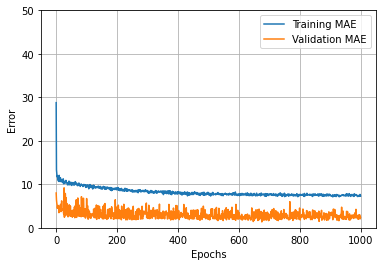

In [245]:
plot_loss(history)

In [247]:
test_predictions = model.predict(X_test).flatten()

25/25 [==============================] - 0s 442us/step


In [248]:
for i,j in zip(y_test.values,test_predictions):
    print(i,j)

101.8 102.9436
16.2 18.322802
108.9 108.164536
110.9 109.555984
1.7000000000000002 3.9610748
44.7 45.550552
134.1 131.68074
169.3 167.044
247.0 238.25836
0.8 2.6191292
0.4 2.1799698
31.200000000000003 34.28396
2.3000000000000003 5.4846992
67.0 66.40486
27.3 24.537697
61.4 62.749916
107.4 107.033455
5.0 8.0414505
119.7 118.34902
38.2 39.25633
206.60000000000002 202.96721
12.700000000000001 13.828865
15.6 16.557884
3.8000000000000003 6.619972
29.700000000000003 31.516193
90.2 88.44338
31.900000000000002 32.166653
20.1 21.59954
23.0 26.629772
45.2 45.389973
84.4 83.477554
164.0 160.93762
106.9 107.41873
3.0 5.470421
114.0 111.82489
2.1 5.2772293
122.10000000000001 119.19618
254.20000000000002 240.72412
8.2 9.67321
14.0 14.456245
187.4 184.46791
287.3 278.72382
12.100000000000001 13.713882
105.60000000000001 104.902084
56.9 56.602245
63.2 62.508373
37.0 37.912094
13.5 15.595802
53.0 56.34266
107.10000000000001 105.31844
32.2 35.19998
34.300000000000004 35.016064
55.0 53.944763
1.8 4.400612

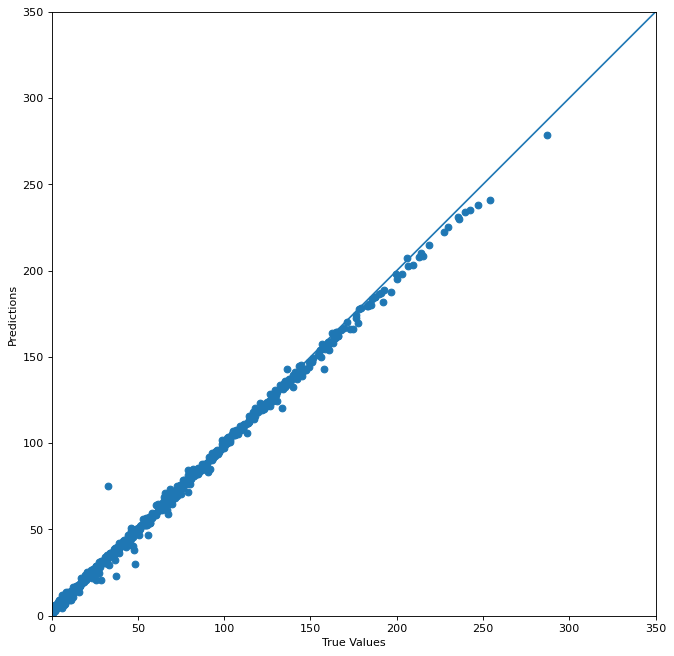

In [249]:
fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 350]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

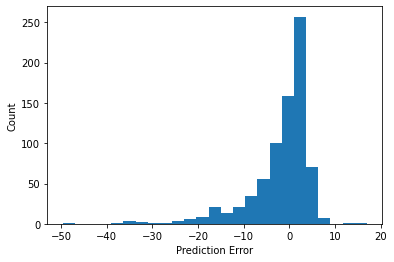

In [20]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [169]:
X_2021 = df_wr[df_wr['season'] == 2021]
y_2021 = X_2021['fantasy_points']
X_test2021 = X_2021.drop(columns=['player_id','position','name','fantasy_points'])
# X_2021 = X_2021.drop(columns=['player_id','position','name','fantasy_points',
#                    'completions', 'attempts', 'passing_yards',
#                    'passing_tds', 'passing_air_yards', 'passing_yards_after_catch',
#                    'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds',
#                    'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs',
#                    'rushing_epa', 'rushing_2pt_conversions'])

X_test2021 = StandardScaler().fit_transform(X_test2021)

val_predz = model.predict(X_test2021).flatten()
X_2021['predicted_points'] = val_predz
X_2021 = X_2021.sort_values(by=['predicted_points'],ascending=False)

7/7 [==============================] - 0s 665us/step


In [171]:
results = X_2021[['season','player_id','name','fantasy_points','predicted_points']]
results = results.reset_index(drop=True)
results

,season,player_id,name,fantasy_points,predicted_points
0,2021,00-0033908,Cooper Kupp,294.50,304.932953
1,2021,00-0031381,Davante Adams,221.30,238.523849
2,2021,00-0036322,Justin Jefferson,222.40,238.502548
3,2021,00-0036900,Ja'Marr Chase,223.60,231.288971
4,2021,00-0035719,Tyshun Samuel,261.96,220.369263
...,...,...,...,...,...
204,2021,00-0036308,Isaiah Coulter,0.00,5.464230
205,2021,00-0036439,Tyrie Cleveland,0.00,5.375656
206,2021,00-0033292,Trent Taylor,4.10,5.167326
207,2021,00-0033589,David Moore,0.00,4.076416


In [152]:
for i,j in zip(y_2021.values,val_predz):
    print(i,j)

44.8 56.386574
55.800000000000004 63.769238
89.7 97.877235
11.4 16.518904
79.10000000000001 91.381744
102.80000000000001 113.30268
49.400000000000006 56.806446
67.6 73.58321
10.1 19.449877
77.3 88.41801
0.0 5.8168926
107.2 123.31687
51.1 58.7447
17.700000000000003 26.079332
9.200000000000001 18.813007
132.8 142.72948
37.199999999999996 47.636284
12.9 20.265427
151.8 146.59276
92.2 94.40913
29.4 39.06872
105.2 114.58997
182.6 118.44582
3.8000000000000003 14.21184
23.000000000000004 26.286562
0.0 6.766903
85.1 93.85764
141.8 154.96786
-0.30000000000000004 7.8110857
43.400000000000006 49.92093
221.3 242.62921
81.0 84.53808
188.5 200.5965
49.0 55.468975
134.5 148.77478
3.8000000000000003 11.774726
63.5 74.986824
66.4 74.57505
182.5 199.5719
62.5 62.91885
2.8 11.339493
40.900000000000006 44.552704
0.0 6.113224
58.7 48.244244
38.300000000000004 46.50821
22.400000000000002 31.673946
42.6 49.83173
1.4000000000000001 8.207904
11.0 20.530363
168.4 179.35735
37.0 46.22247
41.7 46.624294
34.7 49.8

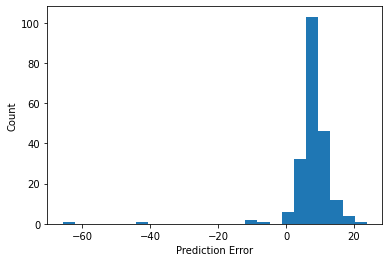

In [179]:
error = val_predz - y_2021.values
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [188]:
cols = list(X_2021.columns)
dropz = ['player_id','position','name','fantasy_points']

for i in dropz:
    cols.remove(i)

In [187]:
# Receiving yards and receiving TDs okay, highly positive valuation
# Target share, air yards shares should have highly positive valuation as well

for i,j in zip(cols, regr.coef_):
    print(i,j)

season -0.10437736215083411
completions 0.1415518563589429
attempts 0.29250705952446493
passing_yards 0.035244871385879444
passing_tds 0.4758143692872491
passing_air_yards 0.0775996559066682
passing_yards_after_catch -0.022877593742857437
passing_2pt_conversions -0.03385839752935906
carries -0.18338609670919703
rushing_yards 2.937415018333411
rushing_tds 1.4198846001230705
rushing_fumbles -0.05848425324058844
rushing_fumbles_lost -0.2505357354347657
rushing_first_downs 0.19775565725437683
rushing_epa -0.18543127308214233
rushing_2pt_conversions 0.09966474741972726
receptions -1.7819894504623166
targets 0.9383164336250617
receiving_yards 39.30314819601167
receiving_tds 18.776556789709613
receiving_fumbles -0.07672689706716299
receiving_fumbles_lost -0.968767500533111
receiving_air_yards -0.11616331023445754
receiving_yards_after_catch 0.25228876687747154
receiving_first_downs 0.1930779368145086
receiving_epa 0.12285380859110218
receiving_2pt_conversions 0.5476101564584157
pacr 4.4408920

In [178]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.04377362e-01  1.41551856e-01  2.92507060e-01  3.52448714e-02
  4.75814369e-01  7.75996559e-02 -2.28775937e-02 -3.38583975e-02
 -1.83386097e-01  2.93741502e+00  1.41988460e+00 -5.84842532e-02
 -2.50535735e-01  1.97755657e-01 -1.85431273e-01  9.96647474e-02
 -1.78198945e+00  9.38316434e-01  3.93031482e+01  1.87765568e+01
 -7.67268971e-02 -9.68767501e-01 -1.16163310e-01  2.52288767e-01
  1.93077937e-01  1.22853809e-01  5.47610156e-01  4.44089210e-16
  1.06581410e-14 -1.33226763e-14 -3.55271368e-15 -5.32907052e-15
  3.85365535e-01 -6.66245235e-01  7.31101107e-01  8.28859220e-02
 -7.81671760e-01 -2.48805529e+00 -4.78192779e-02  5.10978031e+00
 -6.33814992e+00 -8.60919037e-02 -1.12596575e-01  4.18641608e-01
  4.28026009e+00 -4.43914576e-02]
Index(['player_id', 'season', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds',
       'rush

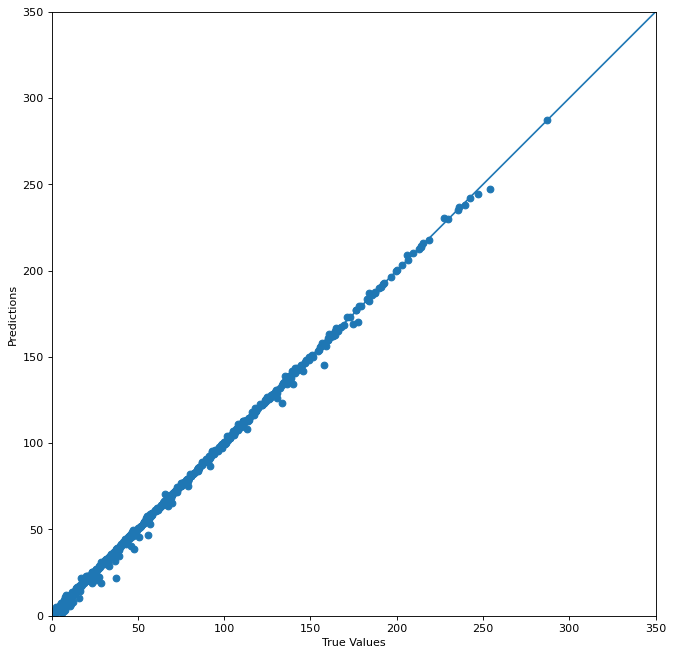

In [26]:
fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 350]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [27]:
# 0 predictive capabilities

new = regr.predict(X_2021)

for i,j in zip(y_2021,new):
    print(i,j)

44.8 55.58372771500481
55.800000000000004 66.60610037511506
89.7 100.34730523703507
11.4 14.14255812782767
79.10000000000001 90.82632420521865
102.80000000000001 114.69027886554687
49.400000000000006 58.829811221215316
67.6 79.51371784057858
10.1 18.61485881464594
77.3 87.95916634778771
0.0 8.172966763429379
107.2 119.20694995975617
51.1 60.33209710721813
17.700000000000003 26.520290511051627
9.200000000000001 18.326296525674735
132.8 147.223231603339
37.199999999999996 47.129577238128995
12.9 21.88591826543434
151.8 163.65957590216877
92.2 98.34286576096676
29.4 38.23551142889852
105.2 117.79309019818098
182.6 151.62188225389252
3.8000000000000003 12.450742157116977
23.000000000000004 32.605532930425206
0.0 8.359819637197788
85.1 96.5796353627536
141.8 155.40134949889728
-0.30000000000000004 7.976654782036057
43.400000000000006 52.576498932968555
221.3 238.57749714619945
81.0 83.08057275250144
188.5 206.001940551642
49.0 58.07320361234759
134.5 148.55333407820825
3.8000000000000003 12

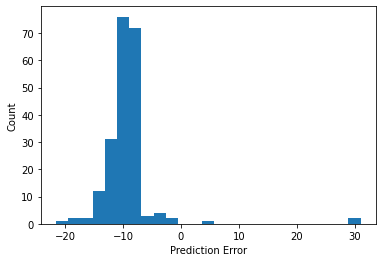

In [28]:
error = y_2021.values - new
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [33]:
valdf = pd.DataFrame()

predo = pd.Series(new)
y_2021 = y_2021.reset_index(drop=True)

valdf['actual'] = y_2021
valdf['prediction'] = predo

valdf['diff'] = valdf['actual'] - valdf['prediction']

valdf.describe()


,actual,prediction,diff
count,208.000000,208.000000,208.000000
mean,53.180481,62.548475,-9.367994
std,56.450520,57.119439,4.714771
min,-0.300000,7.842358,-21.537659
25%,6.700000,15.517914,-10.789321
50%,36.950000,46.811697,-9.264313
75%,79.575000,89.238436,-8.461901
max,294.500000,316.037659,30.978118


In [189]:
valdf = pd.DataFrame()

predoz = pd.Series(val_predz)

valdf['actual'] = y_2021
valdf['prediction'] = predoz

valdf['diff'] = valdf['actual'] - valdf['prediction']

valdf.describe()

,actual,prediction,diff
count,209.000000,0.0,0.0
mean,53.995885,NaN,NaN
std,57.535220,NaN,NaN
min,-0.300000,NaN,NaN
25%,6.800000,NaN,NaN
50%,37.000000,NaN,NaN
75%,81.000000,NaN,NaN
max,294.500000,NaN,NaN


Mean squared error (MSE) (tf.keras.losses.MeanSquaredError) and mean absolute error (MAE) (tf.keras.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

Similarly, evaluation metrics used for regression differ from classification.

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.

Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.

Neural network VS regression:
    - It's hard to understand exactly why the NN worked. Why it's producing quality outputs and why you should trust it
    - On the otherhand, regression is fairly simple to understand. In my case, it produced an equation with an
      R2 of 1.00 which is perfect. So, we were able to find a perfect solution to the problem at hand. Looking at the 
      coefficients though, to try and understand which values had the highest importance in the analysis we can
      conclude that it doesn't make too much sense. It's okay in this case but I would rather trust our NN with 
      predictions.



In [68]:
### To compare our neural network with standard regression models, let's use the following metrics :
### - Mean squared error - Mean absolute error

score = model.evaluate(X_test, y_test)
print("Mean square error from neural net", score[2])
print("Mean absolute error from neural net", score[1])

25/25 [==============================] - 0s 628us/step - loss: 3.9176 - mae: 3.9176 - mse: 35.1132
Mean square error from neural net 35.11318588256836
Mean absolute error from neural net 3.9176459312438965


In [76]:
mse_lr = mean_squared_error(y_test,y_pred)
mae_lr = mean_absolute_error(y_test,y_pred)
print("Mean square error from linear regression", mse_lr)
print("Mean absolute error from linear regression", mae_lr)

Mean square error from linear regression 2.7253765693705923
Mean absolute error from linear regression 0.9116465059005112


In [77]:
# Decision tree

tree = DecisionTreeRegressor()
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
mse_dt = mean_squared_error(y_test,y_pred_tree)
mae_dt = mean_absolute_error(y_test,y_pred_tree)
print("Mean square error from linear regression", mse_dt)
print("Mean absolute error from linear regression", mae_dt)

Mean square error from linear regression 43.69149610389611
Mean absolute error from linear regression 3.5528311688311685
